In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def normalize_string_column_values(df, column_name):
    df[column_name] = df[column_name].str.upper()
    df[column_name] = df[column_name].str.strip()
    df[column_name] = df[column_name].str.replace(' ', '_')
    return df

In [3]:
customers = pd.read_csv('data/customers.csv')

#### Limpieza y creación de columnas útiles en `customers`

In [4]:
customers["address"] = customers["address"].str.upper()
customers.fillna({"address":"UNDEFINED"}, inplace=True)

# Los valores de "address" se caracterizan por tener en alguna parte
# 2 letras mayúsculas seguidas de un espacio y 5 dígitos.
# Interpreto las dos letras mayúsculas como el Estado y los 5 dígitos como el código postal.
pattern = r'([A-Z]{2})\s\d{5}'
customers[["state"]] = customers["address"].str.extract(pattern)

# Chequeo que la extracción haya salido bien
print("Filas totales en dataset customers:", len(customers))
print("Filas con estado no nulos:", customers["state"].notna().sum())
print("Filas con estado nulo:", customers["state"].isna().sum())

null_state_and_null_billing_addr = customers["state"].isna() & customers["address"].str.contains("UNDEFINED")

print("¿Todas las filas que tienen estado nulo, tienen dirección de facturación indefinida?", 
        "Si" if null_state_and_null_billing_addr.sum() == customers["state"].isna().sum() else "No")

customers.fillna({"state":"N/A"}, inplace=True)

Filas totales en dataset customers: 500000
Filas con estado no nulos: 455127
Filas con estado nulo: 44873
¿Todas las filas que tienen estado nulo, tienen dirección de facturación indefinida? Si


In [5]:
customers["registration_date"] = pd.to_datetime(customers["registration_date"], format="%Y-%m-%dT%H:%M:%S.%f", errors="coerce")
customers["registration_year_month"] = pd.DatetimeIndex(customers["registration_date"]).strftime('%Y-%m')
customers["registration_date"] = pd.DatetimeIndex(customers["registration_date"]).date
customers["last_login"] = pd.to_datetime(customers["last_login"], format="%Y-%m-%dT%H:%M:%S.%f", errors="coerce")
# customers["last_login_year_month"] = pd.DatetimeIndex(customers["last_login"]).strftime('%Y-%m')
customers["last_login"] = pd.DatetimeIndex(customers["last_login"]).date

In [6]:
customers.fillna({
    "city":"UNDEFINED", 
    "country":"UNDEFINED", 
    "email":"UNDEFINED",
    "customer_segment": "UNDEFINED"}, inplace=True)
customers = normalize_string_column_values(customers, "customer_segment")
customers = normalize_string_column_values(customers, "country")
customers = normalize_string_column_values(customers, "first_name")
customers = normalize_string_column_values(customers, "last_name")
customers = normalize_string_column_values(customers, "city")
customers = normalize_string_column_values(customers, "email")

#### Análisis de usuarios según la ciudad

In [7]:
# Clientes que están registrados en la misma ciudad pertenecen a distintos paises y estados
# con diferentes códigos postales.
# Esto podría ser correcto, ya que hay ciudades con el mismo nombre en distintos países.
# Aún así es raro.

customers.groupby("city")[["customer_id", "country", "postal_code", "state"]].nunique()

,customer_id,country,postal_code,state
city,,,,
AARONBERG,26,10,24,21
AARONBOROUGH,21,9,16,15
AARONBURGH,22,10,20,18
AARONBURY,23,9,16,18
AARONCHESTER,17,8,17,15
...,...,...,...,...
ZUNIGASTAD,1,1,1,1
ZUNIGATON,2,2,2,2
ZUNIGATOWN,2,2,2,2


In [8]:
# Hay pocas ciudades en que más de un usuario coinciden en ciudad y país
# (~73 mil filas vs ~1200 filas)

customers.groupby("city")[["customer_id", "country", "postal_code", "state"]].nunique() \
    .loc[lambda x: x["country"] == 1].loc[lambda x: x["customer_id"] > 1]

,customer_id,country,postal_code,state
city,,,,
ACEVEDOBURY,2,1,0,2
ACEVEDOSTAD,2,1,1,2
ACOSTATOWN,2,1,2,2
ADRIANAHAVEN,2,1,2,2
ALBERTTON,3,1,3,3
...,...,...,...,...
YORKFORT,2,1,1,2
YUBOROUGH,2,1,2,2
ZAMORALAND,2,1,1,2


#### Análisis por país y segmento de usuario

C:\Users\Patricio\AppData\Local\Temp\ipykernel_26376\4218276228.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


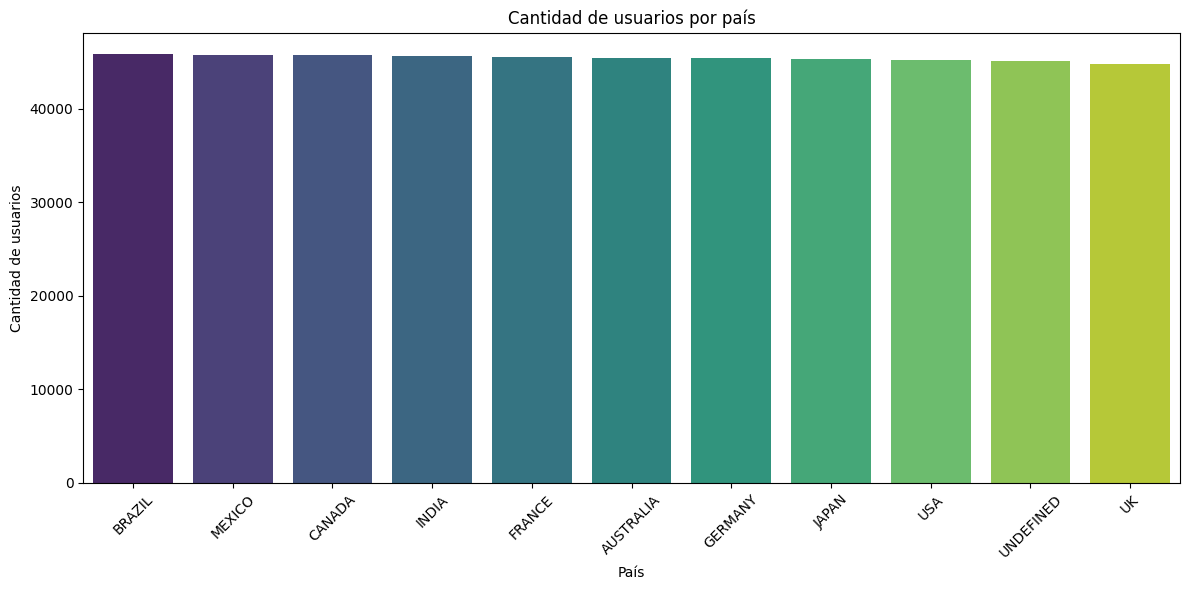

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=customers['country'].value_counts().reset_index(),
    x="country", y="count",palette="viridis")
plt.xticks(rotation=45)
plt.xlabel('País')
plt.ylabel('Cantidad de usuarios')
plt.title('Cantidad de usuarios por país')
plt.tight_layout()

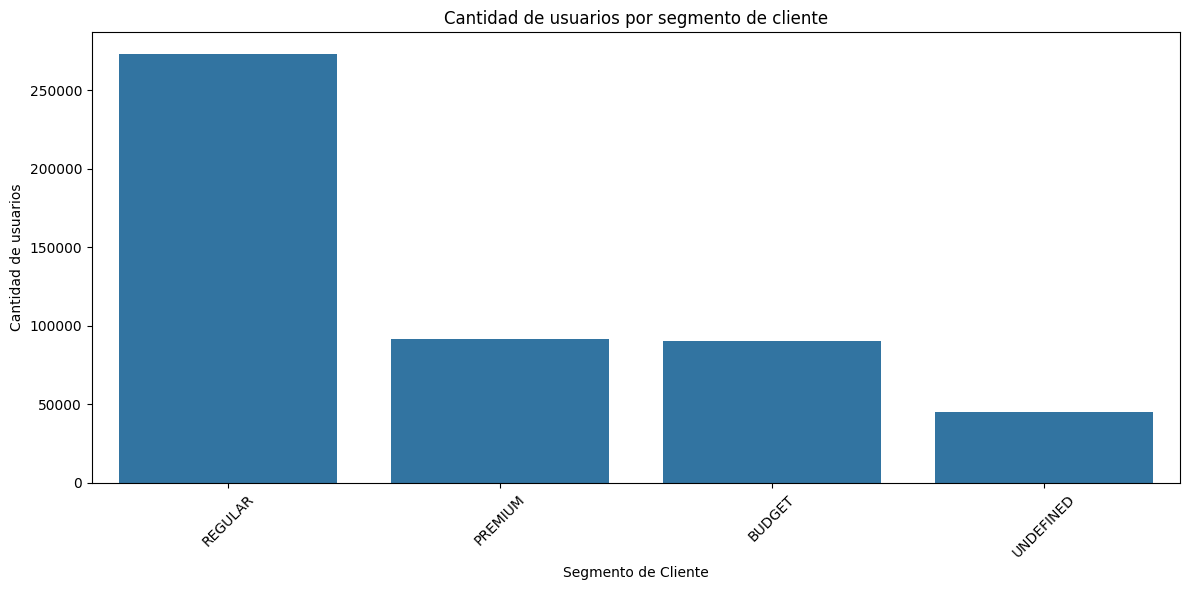

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=customers['customer_segment'].value_counts().reset_index(),
    x="customer_segment", y="count"
)
plt.xticks(rotation=45)
plt.xlabel('Segmento de Cliente')
plt.ylabel('Cantidad de usuarios')
plt.title('Cantidad de usuarios por segmento de cliente')
plt.tight_layout()
plt.show()

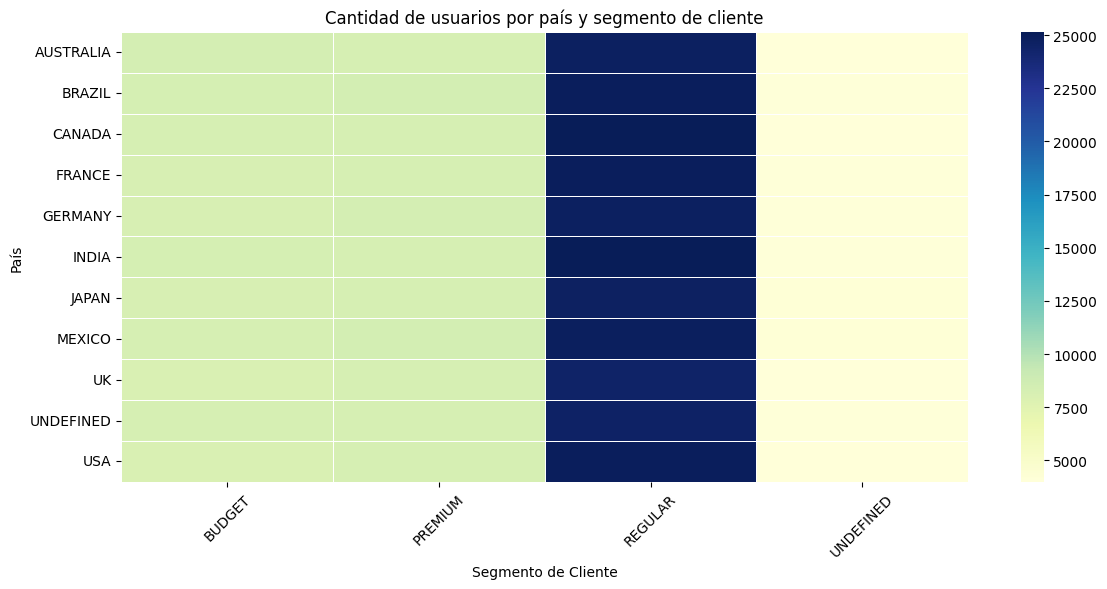

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(
    data=customers.groupby(["country", "customer_segment"])["customer_id"].nunique().unstack(),
    cmap="YlGnBu", linecolor="white", linewidth=0.5
)
plt.xticks(rotation=45)
plt.ylabel('País')
plt.xlabel('Segmento de Cliente')
plt.title('Cantidad de usuarios por país y segmento de cliente')
plt.tight_layout()
plt.show()

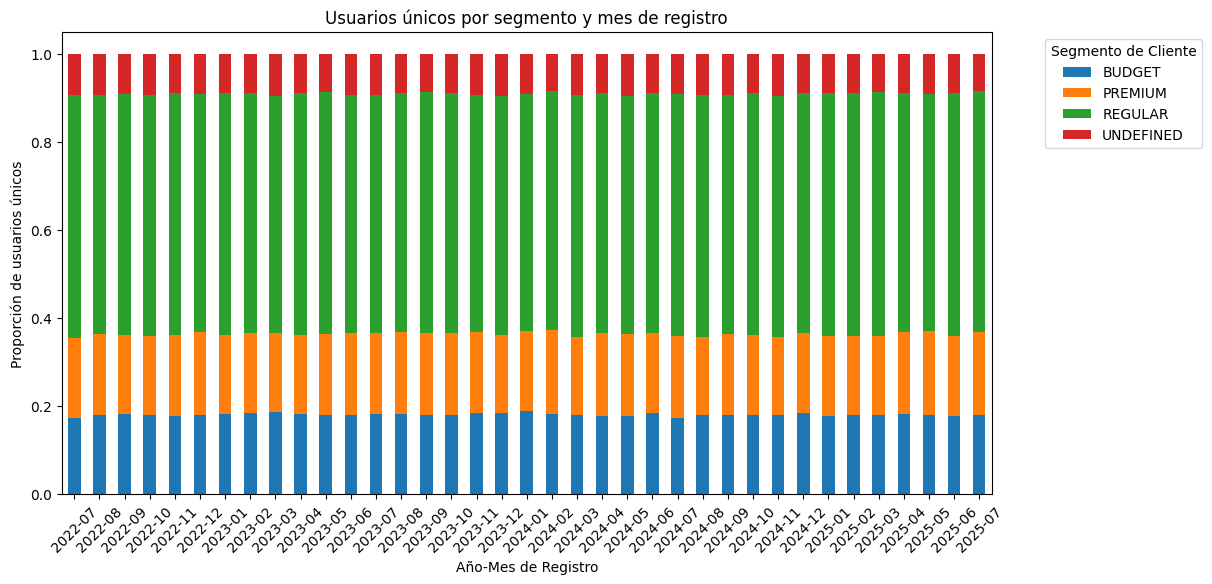

In [ ]:
customer_count_segment_year_month = customers.groupby(["registration_year_month", "customer_segment"])["customer_id"].nunique().unstack()
customer_count_segment_year_month.div(customer_count_segment_year_month.sum(axis=1), axis=0)\
    .plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel('Año-Mes de Registro')
plt.ylabel('Proporción de usuarios únicos')
plt.title('Usuarios únicos por segmento y mes de registro')
plt.xticks(rotation=45)
plt.legend(title='Segmento de Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Text(0.5, 1.0, 'Cantidad de usuarios registrados por mes')

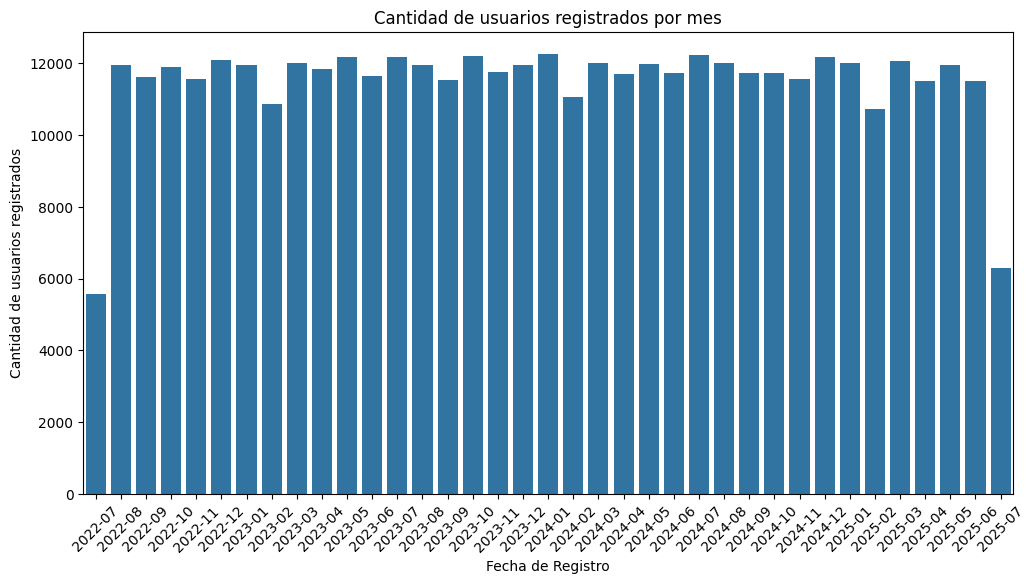

In [ ]:
# # cantidad de usuarios registrados x mes
# plt.figure(figsize=(12,6))
# sns.barplot(
#     data=customers.groupby("registration_year_month")["customer_id"].nunique().reset_index(),
#     x="registration_year_month", y="customer_id"
# )
# plt.xticks(rotation=45)
# plt.xlabel('Fecha de Registro')
# plt.ylabel('Cantidad de usuarios registrados')
# plt.title('Cantidad de usuarios registrados por mes')

In [ ]:
import geopandas as gpd
world = gpd.read_file("world_map/ne_110m_admin_0_countries.shp")
world["NAME"] = world["NAME"].str.upper()

array(['FIJI', 'TANZANIA', 'W. SAHARA', 'CANADA',
       'UNITED STATES OF AMERICA', 'KAZAKHSTAN', 'UZBEKISTAN',
       'PAPUA NEW GUINEA', 'INDONESIA', 'ARGENTINA', 'CHILE',
       'DEM. REP. CONGO', 'SOMALIA', 'KENYA', 'SUDAN', 'CHAD', 'HAITI',
       'DOMINICAN REP.', 'RUSSIA', 'BAHAMAS', 'FALKLAND IS.', 'NORWAY',
       'GREENLAND', 'FR. S. ANTARCTIC LANDS', 'TIMOR-LESTE',
       'SOUTH AFRICA', 'LESOTHO', 'MEXICO', 'URUGUAY', 'BRAZIL',
       'BOLIVIA', 'PERU', 'COLOMBIA', 'PANAMA', 'COSTA RICA', 'NICARAGUA',
       'HONDURAS', 'EL SALVADOR', 'GUATEMALA', 'BELIZE', 'VENEZUELA',
       'GUYANA', 'SURINAME', 'FRANCE', 'ECUADOR', 'PUERTO RICO',
       'JAMAICA', 'CUBA', 'ZIMBABWE', 'BOTSWANA', 'NAMIBIA', 'SENEGAL',
       'MALI', 'MAURITANIA', 'BENIN', 'NIGER', 'NIGERIA', 'CAMEROON',
       'TOGO', 'GHANA', "CÔTE D'IVOIRE", 'GUINEA', 'GUINEA-BISSAU',
       'LIBERIA', 'SIERRA LEONE', 'BURKINA FASO', 'CENTRAL AFRICAN REP.',
       'CONGO', 'GABON', 'EQ. GUINEA', 'ZAMBIA', 'MALAWI', 'M

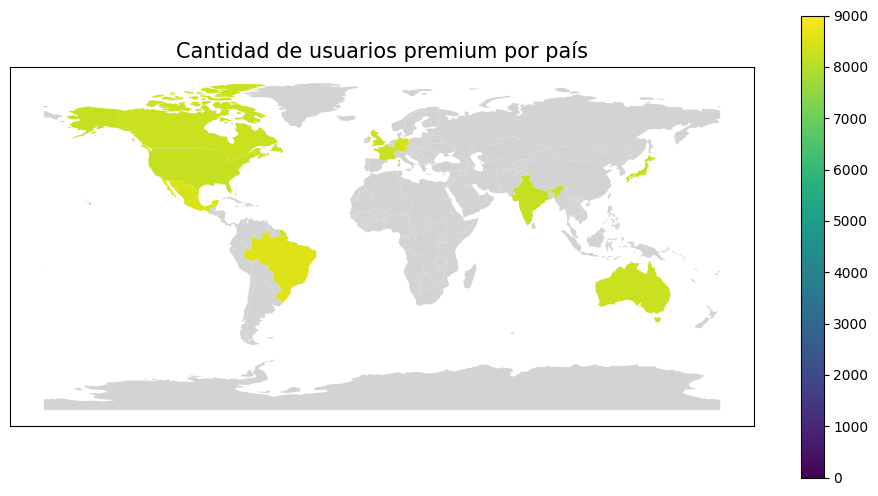

In [ ]:
df = customers.loc[customers["customer_segment"] == "PREMIUM"]['country'].value_counts().reset_index()
map_names = {
    "USA": "UNITED STATES OF AMERICA",
    "UK": "UNITED KINGDOM",
}
df["country"] = df["country"].replace(map_names)

map_names = {
    "USA": "UNITED STATES OF AMERICA",
    "UK": "UNITED KINGDOM",
}
df["country"] = df["country"].replace(map_names)

world_data = world.merge(df, how="left", left_on="NAME", right_on="country")

fig, ax = plt.subplots(figsize=(12,6))
world_data.plot(
    column="count",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey"},
    vmin=0,
    vmax=9000
)
ax.set_title("Cantidad de usuarios premium por país", fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


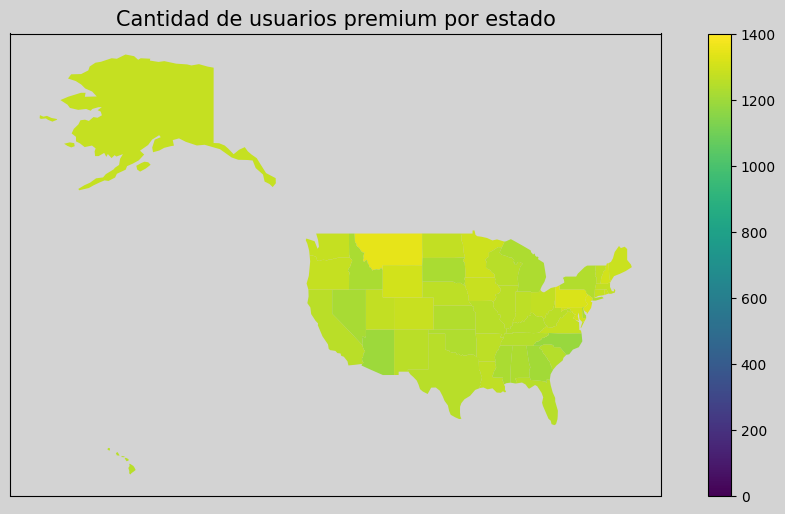

In [ ]:
states = gpd.read_file("states_and_provinces/ne_110m_admin_1_states_provinces.shp")

df = customers.loc[customers["customer_segment"] == "PREMIUM"]['state'].value_counts().reset_index()
states = states.merge(df, how="left", left_on="postal", right_on="state")

fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_facecolor('lightgray')
ax.set_facecolor('lightgray')
states.plot(
    column="count",
    legend=True,
    ax=ax,
    vmin=0,
    vmax=1400
)
ax.set_title("Cantidad de usuarios premium por estado", fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
plt.show()
